In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llmclassificationfinetuning/sample_submission.csv
/kaggle/input/llmclassificationfinetuning/train.csv
/kaggle/input/llmclassificationfinetuning/test.csv
/kaggle/input/deberta_v3/keras/deberta_v3_extra_small_en/2/config.json
/kaggle/input/deberta_v3/keras/deberta_v3_extra_small_en/2/tokenizer.json
/kaggle/input/deberta_v3/keras/deberta_v3_extra_small_en/2/metadata.json
/kaggle/input/deberta_v3/keras/deberta_v3_extra_small_en/2/model.weights.h5
/kaggle/input/deberta_v3/keras/deberta_v3_extra_small_en/2/assets/tokenizer/vocabulary.spm


In [2]:
import pandas as pd
train = pd.read_csv('/kaggle/input/llmclassificationfinetuning/train.csv')
test = pd.read_csv('/kaggle/input/llmclassificationfinetuning/test.csv')
train.head()


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


In [3]:
label_cols = ["winner_model_a", "winner_model_b", "winner_tie"]
train["label"] = train[label_cols].values.argmax(axis=1)  # 0=A,1=B,2=tie


In [4]:
#Statistical analysis

class_counts = train["label"].value_counts(normalize=True).sort_index()
print("Class distribution (0=A,1=B,2=tie):")
print(class_counts)

print("\nP(A wins):", class_counts.get(0, 0.0))
print("P(B wins):", class_counts.get(1, 0.0))
print("P(tie):   ", class_counts.get(2, 0.0))

#Insight: No position bias

Class distribution (0=A,1=B,2=tie):
label
0    0.349079
1    0.341911
2    0.309011
Name: proportion, dtype: float64

P(A wins): 0.34907876193955845
P(B wins): 0.341910677314404
P(tie):    0.30901056074603755


In [5]:
# Lengths in characters
train["len_a_char"] = train["response_a"].astype(str).str.len()
train["len_b_char"] = train["response_b"].astype(str).str.len()
train["len_diff_char"] = train["len_a_char"] - train["len_b_char"]  # >0 => A longer

# Bucket length differences
bins = [-10_000, -500, -200, -50, 0, 50, 200, 500, 10_000]
labels = [
    "<-500", "-500 to -200", "-200 to -50",
    "-50 to 0", "0 to 50", "50 to 200",
    "200 to 500", ">500"
]
train["len_diff_bucket"] = pd.cut(train["len_diff_char"], bins=bins, labels=labels)

# For each bucket, how often A wins vs B wins vs tie?
bucket_stats = (
    train.groupby("len_diff_bucket")["label"]
    .value_counts(normalize=True)
    .unstack(fill_value=0.0)
    .rename(columns={0: "P(A wins)", 1: "P(B wins)", 2: "P(tie)"})
)
print(bucket_stats)

#Insight: verbosity bias

label            P(A wins)  P(B wins)    P(tie)
len_diff_bucket                                
<-500             0.240059   0.513706  0.246236
-500 to -200      0.282903   0.385712  0.331385
-200 to -50       0.309931   0.335862  0.354207
-50 to 0          0.275162   0.270237  0.454601
0 to 50           0.295060   0.291722  0.413218
50 to 200         0.346249   0.294470  0.359281
200 to 500        0.403769   0.278232  0.317999
>500              0.516417   0.232123  0.251460


/tmp/ipykernel_13/694783501.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train.groupby("len_diff_bucket")["label"]


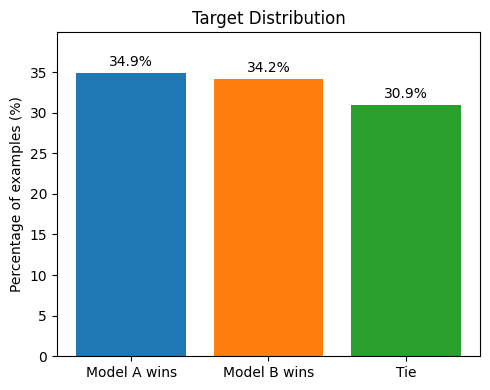

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# If you don't already have this:
# train["label"] = train[["winner_model_a","winner_model_b","winner_tie"]].values.argmax(axis=1)

# Compute normalized distribution
dist = train["label"].value_counts(normalize=True).sort_index()
# Convert to percentages
percentages = (dist * 100).round(1)

labels = ["Model A wins", "Model B wins", "Tie"]
values = percentages.values  # e.g. [35.0, 34.0, 31.0]

plt.figure(figsize=(5,4))
bars = plt.bar(labels, values, color=["tab:blue", "tab:orange", "tab:green"])
plt.ylabel("Percentage of examples (%)")
plt.title("Target Distribution")

# Add value labels on top of bars
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f"{val}%", ha="center", va="bottom", fontsize=10)

plt.ylim(0, max(values) + 5)
plt.tight_layout()
plt.show()


In [7]:
# Create label and basic text length features
import pandas as pd
import numpy as np
import re

# 0 = A wins, 1 = B wins, 2 = tie
label_cols = ["winner_model_a","winner_model_b","winner_tie"]
train["label"] = train[label_cols].values.argmax(axis=1)

def simple_tokenize(text):
    if not isinstance(text, str):
        return []
    return re.findall(r"\w+", text.lower())

# character lengths
train["len_prompt_char"] = train["prompt"].astype(str).str.len()
train["len_a_char"]      = train["response_a"].astype(str).str.len()
train["len_b_char"]      = train["response_b"].astype(str).str.len()

# token counts
train["len_prompt_tok"] = train["prompt"].astype(str).apply(lambda x: len(simple_tokenize(x)))
train["len_a_tok"]      = train["response_a"].astype(str).apply(lambda x: len(simple_tokenize(x)))
train["len_b_tok"]      = train["response_b"].astype(str).apply(lambda x: len(simple_tokenize(x)))


In [8]:
# Show first 5 rows of the new length features
print(train[["prompt",
             "len_prompt_char", "len_a_char", "len_b_char",
             "len_prompt_tok", "len_a_tok", "len_b_tok"]].head())


                                              prompt  len_prompt_char  \
0  ["Is it morally right to try to have a certain...              165   
1  ["What is the difference between marriage lice...              200   
2  ["explain function calling. how would you call...               60   
3  ["How can I create a test set for a very rare ...               87   
4  ["What is the best way to travel from Tel-Aviv...               79   

   len_a_char  len_b_char  len_prompt_tok  len_a_tok  len_b_tok  
0        4538        1206              29        715        212  
1        3114        3649              36        551        603  
2         921        1835               9        155        302  
3        3182        1562              18        557        275  
4        1300         772              15        240        133  


In [9]:
cols = ["len_prompt_char", "len_a_char", "len_b_char",
        "len_prompt_tok", "len_a_tok", "len_b_tok"]

print(train[cols].describe())


       len_prompt_char    len_a_char    len_b_char  len_prompt_tok  \
count     57477.000000  57477.000000  57477.000000    57477.000000   
mean        369.198584   1377.818919   1386.162169       61.036676   
std        1073.341472   1513.932333   1537.800488      170.090692   
min           7.000000      4.000000      4.000000        1.000000   
25%          52.000000    408.000000    413.000000        9.000000   
50%          96.000000   1076.000000   1086.000000       17.000000   
75%         243.000000   1862.000000   1873.000000       43.000000   
max       33056.000000  54058.000000  53830.000000     4917.000000   

          len_a_tok     len_b_tok  
count  57477.000000  57477.000000  
mean     228.351045    229.422865  
std      244.139720    246.671268  
min        0.000000      0.000000  
25%       70.000000     71.000000  
50%      183.000000    185.000000  
75%      310.000000    311.000000  
max     9641.000000   8582.000000  


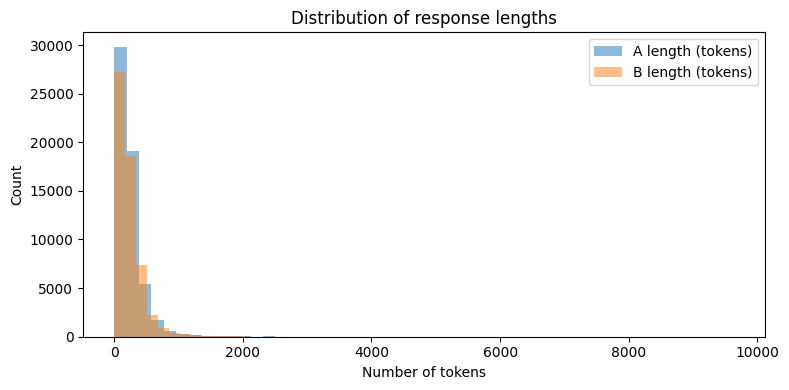

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(train["len_a_tok"], bins=50, alpha=0.5, label="A length (tokens)")
plt.hist(train["len_b_tok"], bins=50, alpha=0.5, label="B length (tokens)")
plt.xlabel("Number of tokens")
plt.ylabel("Count")
plt.title("Distribution of response lengths")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
# 0 = A wins, 1 = B wins, 2 = tie
group_stats = (
    train.groupby("label")[["len_a_tok", "len_b_tok"]]
         .mean()
         .rename(index={0:"A wins",1:"B wins",2:"Tie"})
)

print(group_stats)

#strong Verosity bias


         len_a_tok   len_b_tok
label                         
A wins  258.803030  217.340760
B wins  213.981834  258.807806
Tie     209.849558  210.558077


## 2. Text Length Analysis
We analyzed the word counts of the Prompts and Responses.

- **Prompts**: Generally short (Median: 16 words). Users ask concise questions.
- **Responses**: Longer and more variable (Median: ~170 words).
- **Max Length**: Some responses are extremely long (up to ~8000 words).

**Insight**:
- Most transformer models (like DeBERTa) have a maximum context length (usually 512 or 1024 tokens).
- Since the median response length is ~170 words, `Prompt + Response A + Response B` will typically fit within 512-1024 tokens.
- However, for the very long outliers, we will need to **truncate** the text. We must ensure our tokenizer handles this gracefully so we don't lose the most important parts of the response (usually the beginning and end).

In [12]:
import pandas as pd
import numpy as np

def augment_data(input_path, output_path):
    print(f"Loading data from {input_path}...")
    df = pd.read_csv(input_path)
    original_len = len(df)
    
    print("Creating augmented copy (swapping Response A and B)...")
    df_aug = df.copy()
    
    # Swap responses
    df_aug.rename(columns={
        'response_a': 'temp',
        'response_b': 'response_a',
    }, inplace=True)
    df_aug.rename(columns={
        'temp': 'response_b'
    }, inplace=True)
    
    # Swap target probabilities
    # winner_model_a -> winner_model_b
    # winner_model_b -> winner_model_a
    # winner_tie -> winner_tie (unchanged)
    
    df_aug.rename(columns={
        'winner_model_a': 'temp_win',
        'winner_model_b': 'winner_model_a',
    }, inplace=True)
    df_aug.rename(columns={
        'temp_win': 'winner_model_b'
    }, inplace=True)
    
    # Concatenate original and augmented
    df_final = pd.concat([df, df_aug], axis=0).reset_index(drop=True)
    
    print(f"Original size: {original_len}")
    print(f"Augmented size: {len(df_final)}")
    
    print(f"Saving to {output_path}...")
    df_final.to_csv(output_path, index=False)
    print("Done.")

if __name__ == "__main__":
    augment_data("/kaggle/input/llmclassificationfinetuning/train.csv", "train_augmented.csv")


Loading data from /kaggle/input/llmclassificationfinetuning/train.csv...
Creating augmented copy (swapping Response A and B)...
Original size: 57477
Augmented size: 114954
Saving to train_augmented.csv...
Done.


In [13]:
import kagglehub

# Download selected version
path = kagglehub.model_download("keras/deberta_v3/keras/deberta_v3_extra_small_en/2")

print("Path to model files:", path)

Path to model files: /kaggle/input/deberta_v3/keras/deberta_v3_extra_small_en/2
